Tutorial from: https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb#scrollTo=_IYnV4ZBa3cJ

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)

1.13.0.dev20220915


### Import Data

In [2]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

### Exploring the data

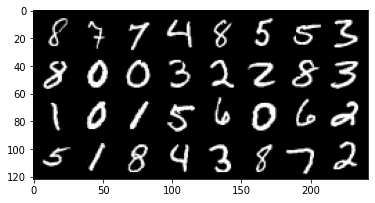

In [3]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
#images, labels = dataiter.next() - not working for some reason
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

Dimensions of the data

In [4]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


### The Model

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

Test with one batch to see it works:

In [6]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


### Training the model:

Setup loss function, optimizer and function to compute accuracy of the model

Note: We use mps instead of cuda due to mac m1!!

In [7]:
learning_rate = 0.001
num_epochs = 5

if torch.has_mps:
    print("gpu is available")
else:
    print("gpu is not available")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gpu is available


In [8]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Training:

In [9]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))  

Epoch: 0 | Loss: 1.5979 | Train Accuracy: 86.64
Epoch: 1 | Loss: 1.4916 | Train Accuracy: 97.30
Epoch: 2 | Loss: 1.4820 | Train Accuracy: 98.19
Epoch: 3 | Loss: 1.4770 | Train Accuracy: 98.65
Epoch: 4 | Loss: 1.4747 | Train Accuracy: 98.85


Compute the accuracy on the test data:

In [10]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.26


## References
- [Building RNNs is Fun with PyTorch and Google Colab](https://colab.research.google.com/drive/1NVuWLZ0cuXPAtwV4Fs2KZ2MNla0dBUas)
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
- [Tensorflow 2.0 Quickstart for experts](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G) 

### Check gpu with mac m1

In [11]:
import math
dtype = torch.float
device = torch.device("mps")

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

# Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 1854.48974609375
199 1229.2774658203125
299 815.85302734375
399 542.47412109375
499 361.70111083984375
599 242.16387939453125
699 163.119140625
799 110.85057067871094
899 76.28744506835938
999 53.43254852294922
1099 38.3194580078125
1199 28.325855255126953
1299 21.717546463012695
1399 17.347702026367188
1499 14.458061218261719
1599 12.547273635864258
1699 11.283735275268555
1799 10.448199272155762
1899 9.895712852478027
1999 9.53038501739502
Result: y = -0.0005262569757178426 + 0.8307845592498779 x + 9.07899157027714e-05 x^2 + -0.08963834494352341 x^3
